In [1]:
cd /home/mffang/workspace/Poisson-regression

/home/mffang/workspace/Poisson-regression


In [2]:
# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

import RADOM
print(RADOM.__version__)

from RADOM.inference import Trajectory
from RADOM.mixtures import PoissonMixture, GammaPoissonMixture
from RADOM.preprocess import *
from RADOM.plotting import *

2023.05.08.08


In [3]:
from scipy.stats import spearmanr
import scanpy as sc
import scvelo as scv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmasher as cmr
from tqdm import tqdm

# Load data

In [4]:
alldata = sc.read('data/bone_marrow.h5ad')
alldata

AnnData object with n_obs × n_vars = 5780 × 14319
    obs: 'clusters', 'palantir_pseudotime'
    uns: 'clusters_colors'
    obsm: 'X_tsne'
    layers: 'spliced', 'unspliced'

In [5]:
adata = alldata[alldata.obs['clusters'].isin(['HSC_1', 'HSC_2', 'Precursors','Ery_1','Ery_2'])]
adata

View of AnnData object with n_obs × n_vars = 3775 × 14319
    obs: 'clusters', 'palantir_pseudotime'
    uns: 'clusters_colors'
    obsm: 'X_tsne'
    layers: 'spliced', 'unspliced'

In [6]:
clusters = adata.obs["clusters"]
Clusters = ['HSC_1', 'HSC_2', 'Precursors','Ery_1','Ery_2']

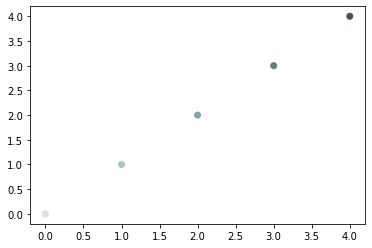

In [7]:
color_palette = ["#d3e4e2","#77a6ac","#405759"]
from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(Clusters))

cell_colors = np.zeros((adata.n_obs,3))

for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    cell_colors[idx] = cmap_cluster(i)[:3]
plt.scatter(x=np.arange(len(Clusters)), y=np.arange(len(Clusters)),c=cmap_cluster(np.arange(len(Clusters))))

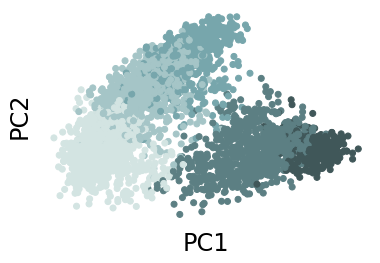

In [8]:
from sklearn.decomposition import PCA

total_UMI = adata.X.toarray().sum(axis=1)
r = total_UMI/np.mean(total_UMI)
pca = PCA(n_components=2)
x = pca.fit_transform(np.log(1+adata.X/total_UMI[:,None]*np.mean(total_UMI)))
adata.obsm['X_pca']=x

fig, ax = plt.subplots(1,1)
ax.scatter(x[:,0],x[:,1],c=cell_colors);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

In [9]:
adata.var_names

Index(['FO538757.1', 'AP006222.2', 'RP4-669L17.10', 'LINC00115', 'FAM41C',
       'RP11-54O7.3', 'NOC2L', 'HES4', 'RNF223', 'TNFRSF18',
       ...
       'AC010084.1', 'PCDH11Y', 'TBL1Y', 'TTTY15', 'USP9Y', 'DDX3Y', 'TMSB4Y',
       'FAM224A', 'EIF1AY', 'RPS4Y2'],
      dtype='object', name='index', length=14319)

In [10]:
marker_genes = ['SMIM1','CNN3','SCUBE2','KLF1','GATA1','GATA2','CD34','ITGA2B']

In [11]:
gene_length_file = np.loadtxt("data/gg_200524_mouse_genome_polyA_cum_1.txt",dtype="str")
gene_length = np.array([int(gene[1]) for gene in gene_length_file])
gene_name = np.array([gene[0].upper() for gene in gene_length_file])

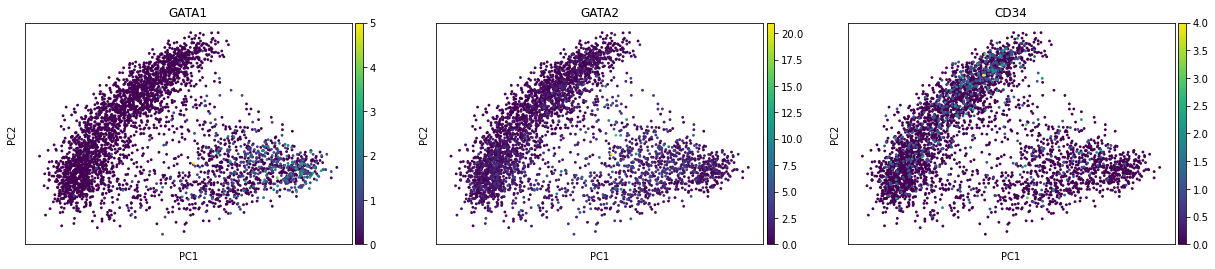

In [12]:
sc.pl.pca(adata,color=['GATA1','GATA2','CD34'])

# Select genes

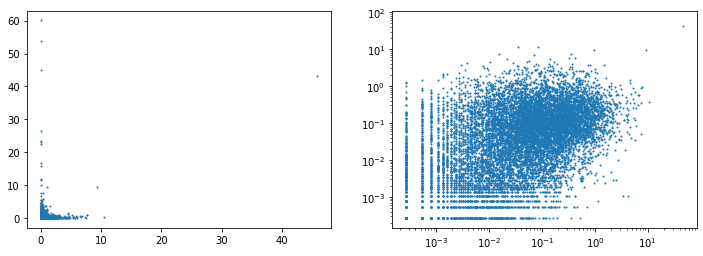

In [13]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')

In [14]:
idx = (adata.layers["unspliced"].toarray().mean(0) > 0) 
U = adata.layers["unspliced"][:,idx].toarray()
n,p = U.shape
X = U
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
su = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total U counts =", str(su))


idx = adata.layers["spliced"].toarray().mean(0) > 0
S = adata.layers["spliced"][:,idx].toarray()
n,p = S.shape
X = S
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
ss = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total S counts =", str(ss))

idx = (adata.layers["spliced"].toarray().mean(0) > 0) | (adata.layers["unspliced"].toarray().mean(0) > 0)
U=adata.layers["unspliced"][:,idx].toarray()
S=adata.layers["spliced"][:,idx].toarray()
X = S + U
n,p = X.shape
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
s1 = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total counts =", str(s1))

X_total = X.sum(1)
s2 = (X_total.var()-X_total.mean())/X_total.mean()**2
print("s estimated by total counts =", str(s2))

s estimated by normalized covariance of total U counts = 0.1551206941657817
s estimated by normalized covariance of total S counts = 0.22314175828210708
s estimated by normalized covariance of total counts = 0.17540396882569073
s estimated by total counts = 0.21357604000503952


s estimated by normalized covariance of Poission genes = 0.1471832820054005


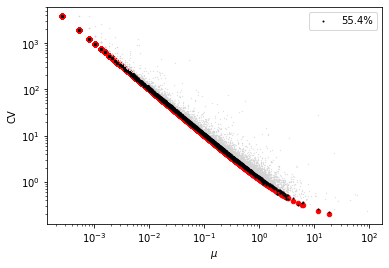

In [15]:
a=1
s=s1

X_bar = np.mean(U + S, axis=0)
X_var = np.var(U + S, axis=0)

Pgene_mask = (X_mean > 0) & (X_var/(a*X_mean + s*X_mean**2) < 1.1)
Pgenes = adata.var_names[idx][Pgene_mask]

P = (S + U)[:,Pgene_mask]
n,p = P.shape
P_cov = np.cov(P,rowvar=False)
P_mean = np.mean(P,axis=0)
P_rho = P_cov/P_mean[:,None]/P_mean[None,:]
s = (np.sum(P_rho)-np.sum(np.diag(P_rho)))/((p-1)*p)
print("s estimated by normalized covariance of Poission genes =", str(s))

plt.scatter(X_bar[Pgene_mask], a/X_bar[Pgene_mask] + s, c='r', s=20)
plt.scatter(X_bar, X_var/X_bar**2,c='lightgray',alpha=1, s=0.1)
plt.scatter(X_bar[Pgene_mask], X_var[Pgene_mask]/X_bar[Pgene_mask]**2,c='k', s=1, label=str(np.around(100*np.sum(Pgene_mask)/len(X_bar),1))+"%")
plt.xlabel(r'$\mu$')
plt.ylabel(r'CV')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc="upper right")

read_depth =  (U + S)[:,Pgene_mask].sum(1)
rd = read_depth/read_depth.mean()

s estimated by normalized covariance of Poission genes = 0.14644686430491782


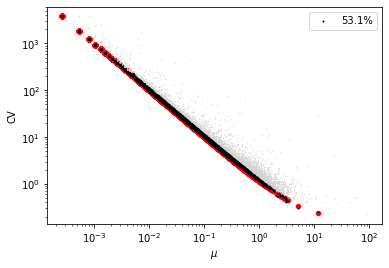

In [16]:
Pgene_mask = (X_mean > 0) & (X_var/(a*X_mean + s*X_mean**2) < 1.1)
Pgenes = adata.var_names[idx][Pgene_mask]

P = (S + U)[:,Pgene_mask]
n,p = P.shape
P_cov = np.cov(P,rowvar=False)
P_mean = np.mean(P,axis=0)
P_rho = P_cov/P_mean[:,None]/P_mean[None,:]
s = (np.sum(P_rho)-np.sum(np.diag(P_rho)))/((p-1)*p)
print("s estimated by normalized covariance of Poission genes =", str(s))

plt.scatter(X_bar[Pgene_mask], a/X_bar[Pgene_mask] + s, c='r', s=20)
plt.scatter(X_bar, X_var/X_bar**2,c='lightgray',alpha=1, s=0.1)
plt.scatter(X_bar[Pgene_mask], X_var[Pgene_mask]/X_bar[Pgene_mask]**2,c='k', s=1, label=str(np.around(100*np.sum(Pgene_mask)/len(X_bar),1))+"%")
plt.xlabel(r'$\mu$')
plt.ylabel(r'CV')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc="upper right")

read_depth =  (U + S)[:,Pgene_mask].sum(1)
rd = read_depth/read_depth.mean()

In [17]:
var_threshold = 1.2
U_mean = adata.layers["unspliced"].toarray().mean(0)
S_mean = adata.layers["spliced"].toarray().mean(0)
U_var = adata.layers["unspliced"].toarray().var(0)
S_var = adata.layers["spliced"].toarray().var(0)
fitted_idx = (U_mean > 0.01) & (S_mean > 0.01) \
    & (np.abs(np.log(S_mean/U_mean)) < 4) \
    & (U_var/(a*U_mean + s2*U_mean**2) > var_threshold) \
    & (S_var/(a*S_mean + s2*S_mean**2) > var_threshold)
fitted_genes=adata.var_names[fitted_idx]

In [18]:
fitted_genes = fitted_genes[fitted_genes.isin(gene_name)]
fitted_idx = adata.var_names.isin(fitted_genes)

In [19]:
cell_cycle_genes = np.loadtxt("data/cell_cycle_genes.txt",dtype="str")
fitted_genes = fitted_genes[~fitted_genes.isin(cell_cycle_genes)]
len(fitted_genes)

251

(3775, 251, 2)

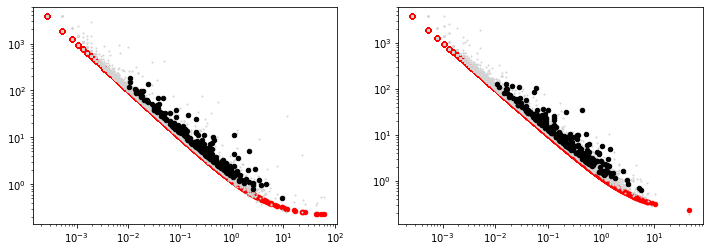

In [20]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(S_mean, a/S_mean + s2, c='r', s=20)
ax[0].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=1)
ax[0].scatter(S_mean[fitted_idx], S_var[fitted_idx]/S_mean[fitted_idx]**2, c='k', s=20)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].scatter(U_mean, a/U_mean + s2, c='r', s=20)
ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=1)
ax[1].scatter(U_mean[fitted_idx], U_var[fitted_idx]/U_mean[fitted_idx]**2, c='k', s=20)
ax[1].set_xscale('log')
ax[1].set_yscale('log')

X=np.zeros((n,fitted_idx.sum(),2))
X[:,:,0]=adata.layers["unspliced"][:,fitted_idx].toarray()
X[:,:,1]=adata.layers["spliced"][:,fitted_idx].toarray()
fitted_genes=adata.var_names[fitted_idx]
X.shape

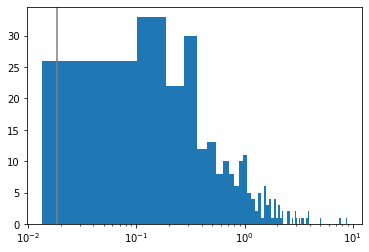

In [21]:
Ub_gene_idx = np.array([ np.where(gene_name == fitted_gene)[0][0]  for fitted_gene in fitted_genes ])
Ub = 10**(-5)*gene_length[Ub_gene_idx]
plt.hist(Ub,bins=100);
plt.xscale('log')
plt.axvline(x=np.e**(-4),color='gray');

In [22]:
plot_idx = [np.where(fitted_genes==gene)[0] for gene in marker_genes]
plot_idx = np.concatenate(plot_idx).ravel()
print(fitted_genes[plot_idx])

Index(['KLF1', 'GATA1', 'GATA2', 'ITGA2B'], dtype='object', name='index')


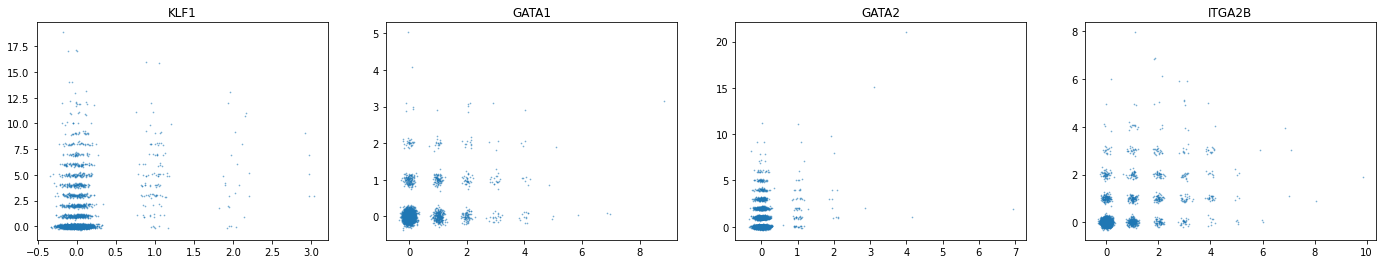

In [23]:
pp = min(10,len(plot_idx))
fix, ax = plt.subplots(1,pp,figsize=(6*pp,4))
for i in range(pp):
    j = plot_idx[i]
    ax[i].set_title(fitted_genes[j])
    ax[i].scatter(X[:,j,0]+np.random.normal(0,0.1,X.shape[0]),X[:,j,1]+np.random.normal(0,0.1,X.shape[0]),s=0.5,alpha=0.5) #,c=adata.obs['louvain'])

# Mixtures fitting

In [24]:
cell_idx = clusters.isin(Clusters)
X_mix = X[cell_idx]

In [25]:
PMs = []
for nc in range(2,7):
    PM = PoissonMixture(n_components=nc,verbose=0)
    Q, elbo = PM.fit(X_mix,warm_start=False,read_depth=rd,epoch=5,n_init=3)
    PMs.append(PM)
    print(nc,PM.compute_AIC(X_mix))

2 -336.2019361871826
3 -332.1518865219513
4 -326.36462986559496
5 -323.6891458807681
6 -321.07765618748914


In [26]:
for PM in PMs:
    print(PM.compute_BIC(X_mix))

-337.0320469739364
-333.39746569252327
-328.025677419985
-325.7656618189762
-323.56964050951535


In [27]:
PM = PoissonMixture(n_components=3,verbose=0)
Q, elbo = PM.fit(X_mix,warm_start=False,read_depth=rd,epoch=10,n_init=5)
PM.weights

array([0.34176062, 0.39791976, 0.26031962])

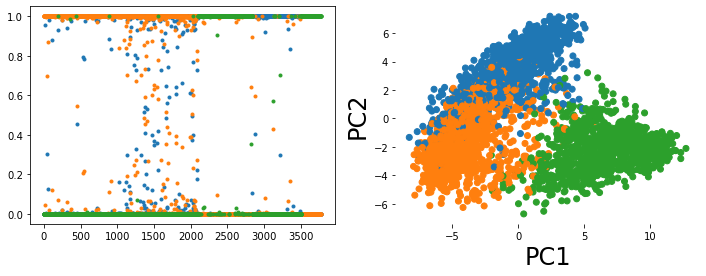

In [28]:
tab_colors = plt.cm.tab10(np.arange(10))
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(Q[np.argsort(clusters[cell_idx])],'.');
ax[1].scatter(x[cell_idx,0],x[cell_idx,1],c=tab_colors[np.argmax(Q,axis=1)]);
ax[1].set_xlabel('PC1',fontsize=24)
ax[1].set_ylabel('PC2',fontsize=24)
ax[1].set_frame_on(False)

(array([1.000e+00, 1.000e+00, 1.700e+01, 5.700e+01, 1.530e+02, 3.470e+02,
        7.140e+02, 9.510e+02, 1.191e+03, 3.430e+02]),
 array([-984.88368131, -896.61041074, -808.33714017, -720.0638696 ,
        -631.79059903, -543.51732846, -455.24405789, -366.97078732,
        -278.69751675, -190.42424618, -102.15097561]),
 <BarContainer object of 10 artists>)

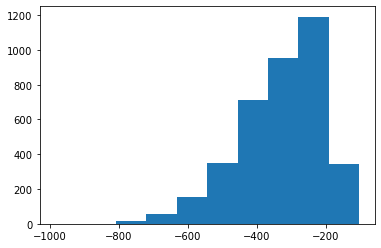

In [29]:
cell_logL = PM.compute_cell_lower_bound(X_mix)
plt.hist(cell_logL)

Text(0.5, 1.0, 'intercept test p value')

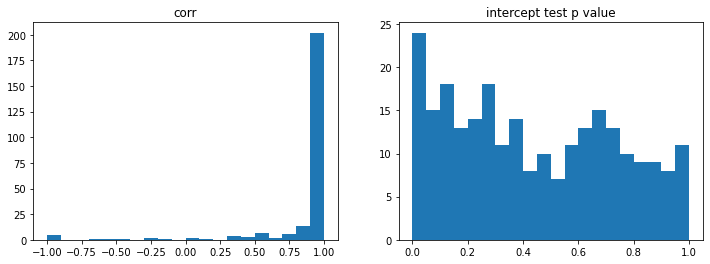

In [30]:
slope, intercept, corr, pval = linear_regression(PM.theta)
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].hist(corr,bins=np.linspace(-1,1,21))
ax[0].set_title('corr')
ax[1].hist(pval,bins=np.linspace(0,1,21))
ax[1].set_title('intercept test p value')

# Trajectory fitting

In [31]:
elbos = {}
traj_params={'r':rd,"Ub":Ub,"lambda_tau":0,"lambda_a":0}

## Fine cluster

In [32]:
m=100
weight0 = np.zeros((adata.n_obs,m))
Prior_Clusters = [['HSC_1', 'HSC_2', 'Precursors'], ['Ery_1','Ery_2']]
for i,Cluster in enumerate(Prior_Clusters):
    idx = clusters.isin(Cluster)
    print(idx.sum())
    weight0[idx,int(i*m/len(Prior_Clusters)):int((i+1)*m/len(Prior_Clusters))] += 1
weight0=weight0/weight0.sum(axis=1,keepdims=True)
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
Q0 = weight0[:,None]

2768
1007


In [33]:
topo = np.array([[0,1,2]])
tau = (0,24,48) # ~48 hours
traj = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj = traj.fit(X,warm_start=True,fit_tau=True,params=traj_params,Q=Q0,parallel=True,n_threads=10,epoch=100)
print(traj.elbos[-1])

fitting with warm start


100%|██████████| 100/100 [03:11<00:00,  1.92s/it]

-327.14575999905287


[ 0.         20.84189055 48.        ]


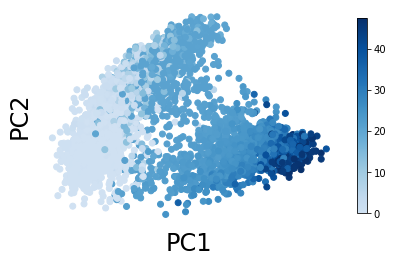

In [34]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

[]

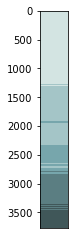

In [35]:
order = np.argsort(traj.Q[:,0]@traj.t)
cluster = np.zeros(adata.n_obs)
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    cluster[idx] = i
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
fig, ax = plt.subplots(1,1,figsize=(0.5,4))
ax.imshow(cluster[order,None],aspect="auto",cmap=cmap_cluster)
ax.set_xticks([])

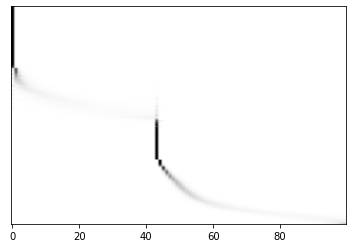

In [36]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax=plot_t(traj,l=0,ax=ax,order_cells=True)
ax.set_yticks([]);

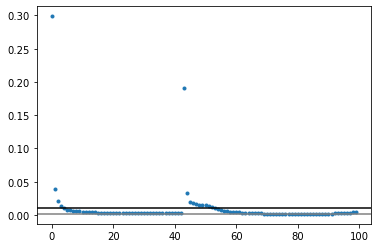

In [37]:
plt.plot(traj.Q[:,0].mean(0),'.')
plt.axhline(y=1/traj.m,c='k')
plt.axhline(y=0.1/traj.m,c='gray')

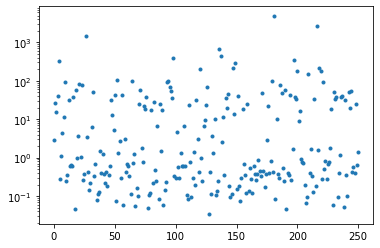

In [38]:
plt.plot(traj.theta[:,[-2]],'.')
plt.yscale('log')

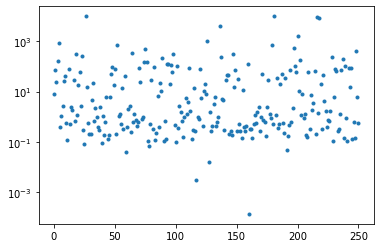

In [39]:
plt.plot(traj.theta[:,[-1]],'.')
plt.yscale('log')

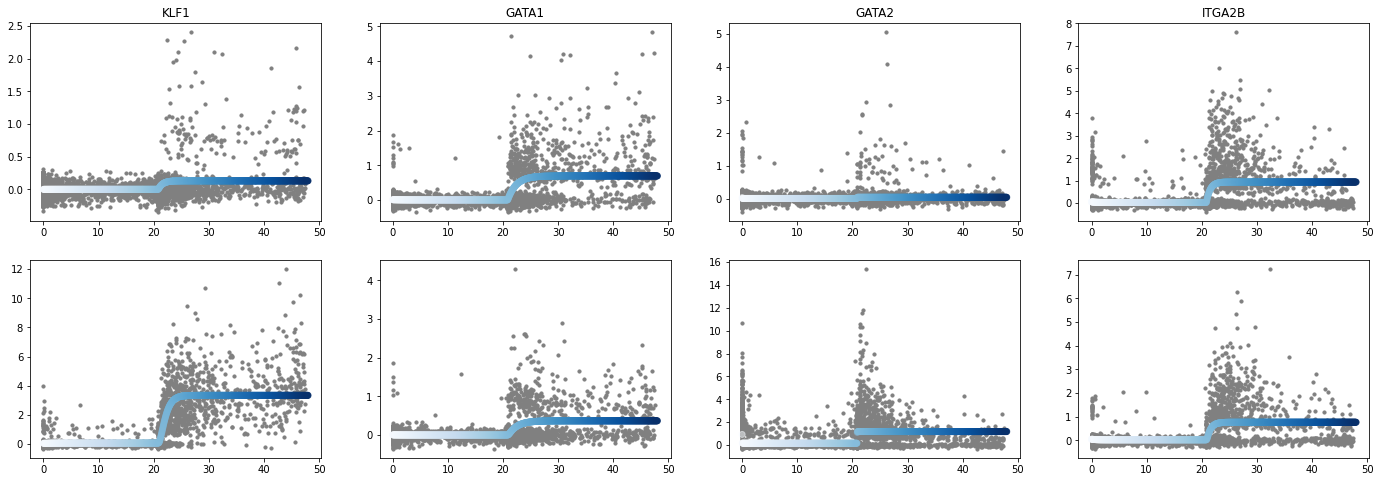

In [40]:
plot_y(traj,X=X/rd[:,None,None],idx=plot_idx,gene_name=fitted_genes);

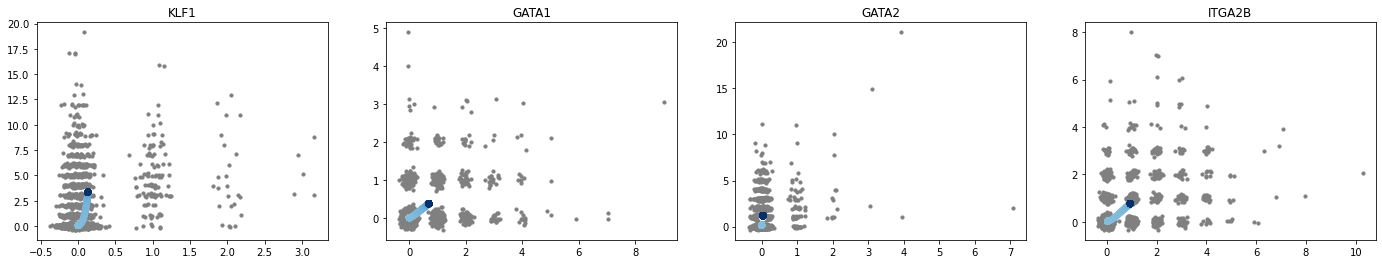

In [41]:
plot_phase(traj,X=X,idx=plot_idx,gene_name=fitted_genes);

14


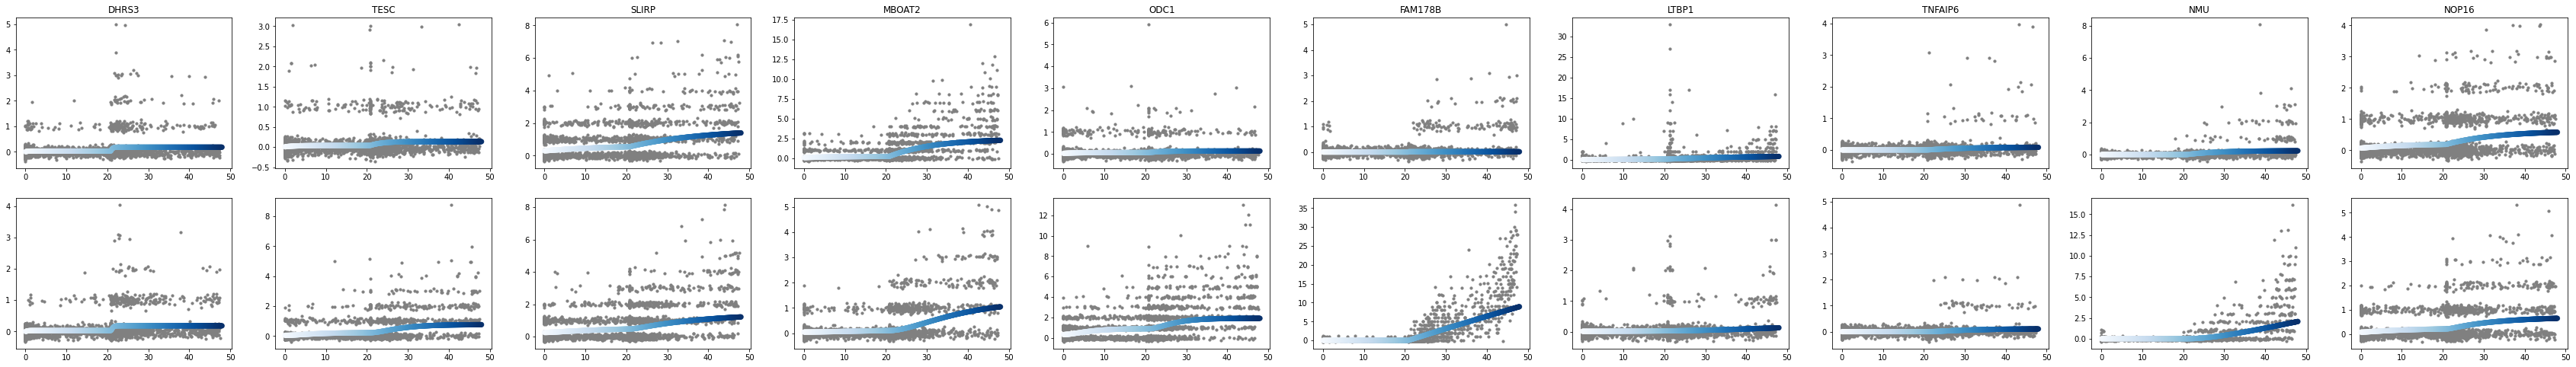

In [42]:
n, p, _ = X.shape
up_mask = (traj.theta[:,2] > 2*traj.theta[:,1]) & (traj.theta[:,1] > 2*traj.theta[:,0])
print(up_mask.sum())
up_idx = np.arange(p)[up_mask]
plot_y(traj,X=X,idx=up_idx[:10],gene_name=fitted_genes);

In [43]:
plot_marker_genes = ['CD34','GATA1',"GATA2",'ITGA2B']

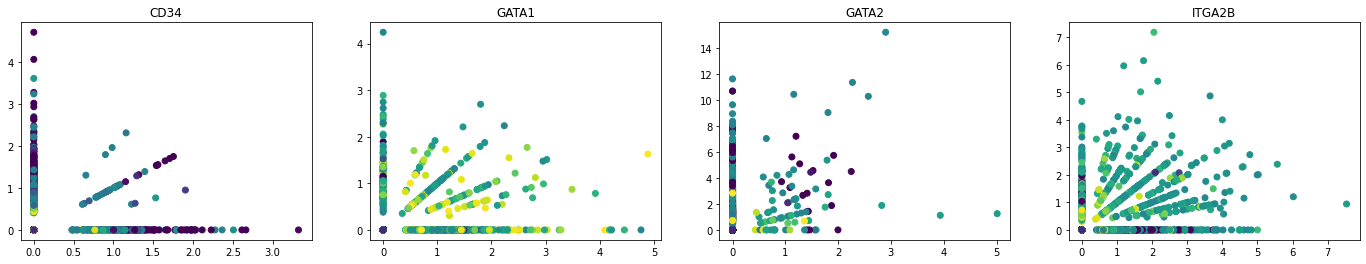

In [44]:
fig,ax = plt.subplots(1,len(plot_marker_genes),figsize=(6*len(plot_marker_genes),4))
for i,gene in enumerate(plot_marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[i].set_title(gene)
    ax[i].scatter(adata.layers["unspliced"].toarray()[:,j]/rd,adata.layers["spliced"].toarray()[:,j]/rd,c=traj.Q[:,0]@traj.t)

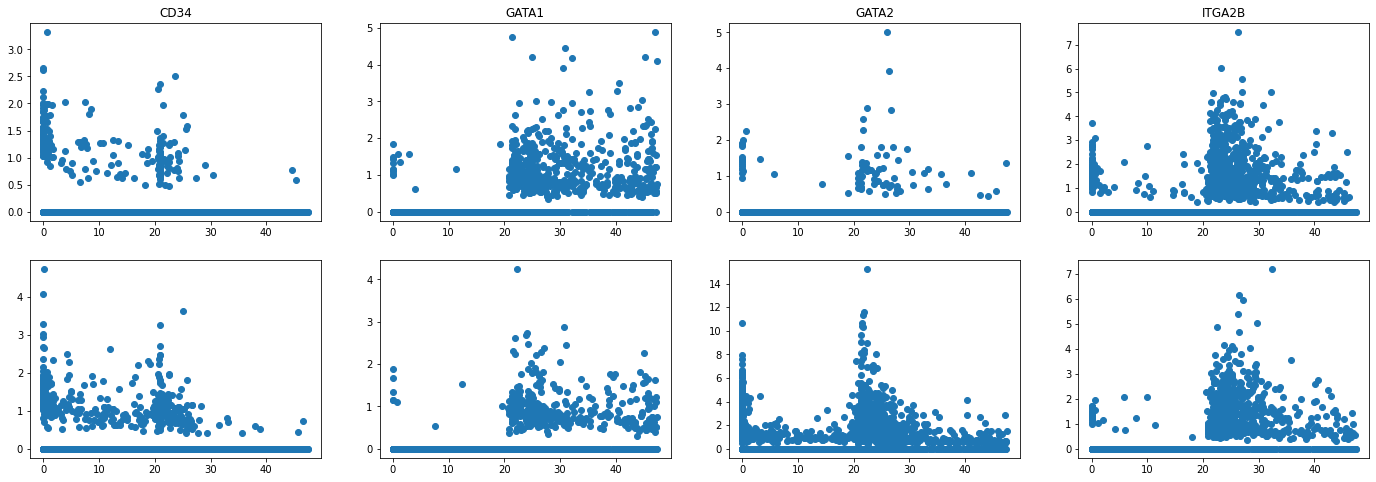

In [45]:
fig,ax = plt.subplots(2,len(plot_marker_genes),figsize=(6*len(plot_marker_genes),8))
for i,gene in enumerate(plot_marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[0,i].set_title(gene)
    ax[0,i].scatter(traj.Q[:,0]@traj.t,adata.layers["unspliced"].toarray()[:,j]/rd)
    ax[1,i].scatter(traj.Q[:,0]@traj.t,adata.layers["spliced"].toarray()[:,j]/rd)

[Text(0, 0, 'α0'), Text(1, 0, 'α1'), Text(2, 0, 'α2')]

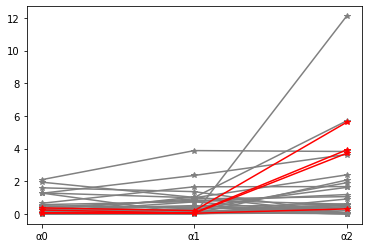

In [46]:
p=30
fig,ax = plt.subplots(1,1)
for j in range(p):
    ax.plot(traj.theta[j,[0,1,2]],'-*',color='gray')
for j in plot_idx:
    ax.plot(traj.theta[j,[0,1,2]],'-*',color='red')

x_label_list = ['α0', 'α1', 'α2']
ax.set_xticks([0,1,2])
ax.set_xticklabels(x_label_list)
#plt.yscale('log')

In [47]:
#from scipy.spatial import distance

#S = data.X.toarray()
#dist = distance.cdist(S, S, 'minkowski', p=1.)

#order = np.argsort(data.obs["t_hat"])
#sorted_dist = dist[order,:][:,order]
#plt.imshow(sorted_dist,aspect="auto");

#order = np.argsort(data.obs["celltype"])
#sorted_dist = dist[order,:][:,order]
#plt.imshow(sorted_dist,aspect="auto");

## Fitting without prior

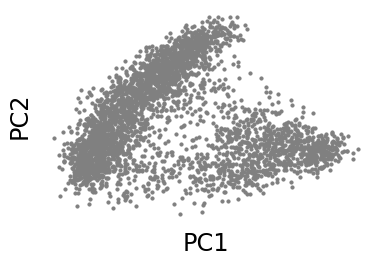

In [48]:
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c='grey',s=10);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

### two_species_ss

In [49]:
from multiprocessing import Pool

tau = (0,24,48)
topo = np.array([[0,1,2]])
Input_args = []
def fit_wrapper(seed):
    traj = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj = traj.fit(X,m=100,n_init=1,params=traj_params,perm_theta=False,epoch=100,parallel=False,n_threads=1,seed=seed)
    return traj
    
for seed in range(100):
    Input_args.append([seed])
            
with Pool(20) as pool:      
    trajs = pool.starmap(fit_wrapper, Input_args, chunksize=1)

Text(0.5, 1.0, 'Random initialiazation')

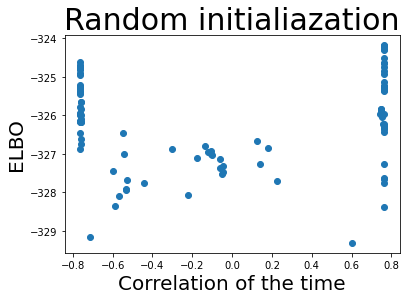

In [50]:
corrs = []
elbos = []
for traj in trajs:
    right_t = Q0[:,0] @ traj.t
    t_hat = traj.Q[:,0] @ traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

In [51]:
traj = trajs[np.argmax(elbos)]
np.max(elbos)

-324.1817779813873

[ 0.         22.21300029 48.        ]


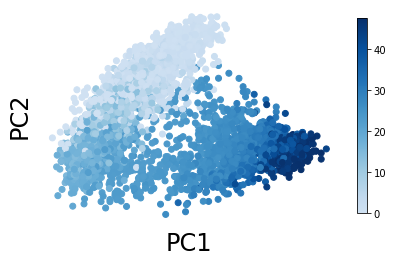

In [52]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

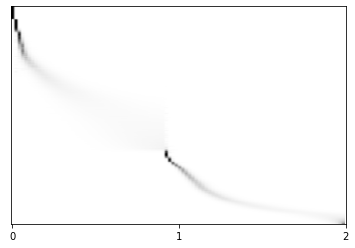

In [53]:
ax = plot_t(traj,l=0,order_cells=True)
x_label_list = ['0', '1', '2']
ax.set_xticks([0,50,100])
ax.set_xticklabels(x_label_list);
ax.set_yticks([]);

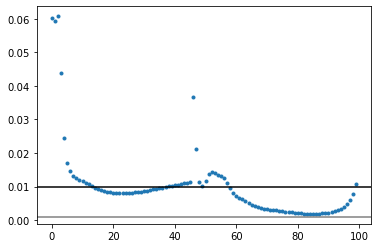

In [54]:
plt.plot(traj.Q.sum((0,1))/traj.Q.sum(),'.')
plt.axhline(y=1/traj.m,c='k')
plt.axhline(y=0.1/traj.m,c='gray')

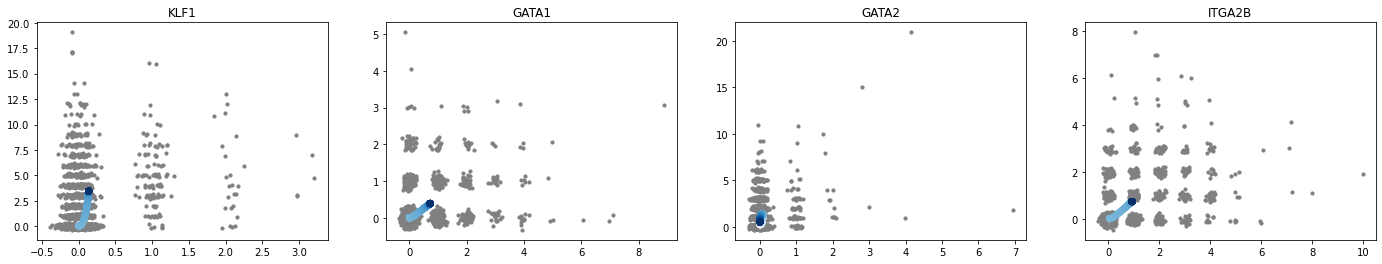

In [55]:
plot_phase(traj,idx=plot_idx,gene_name=fitted_genes);

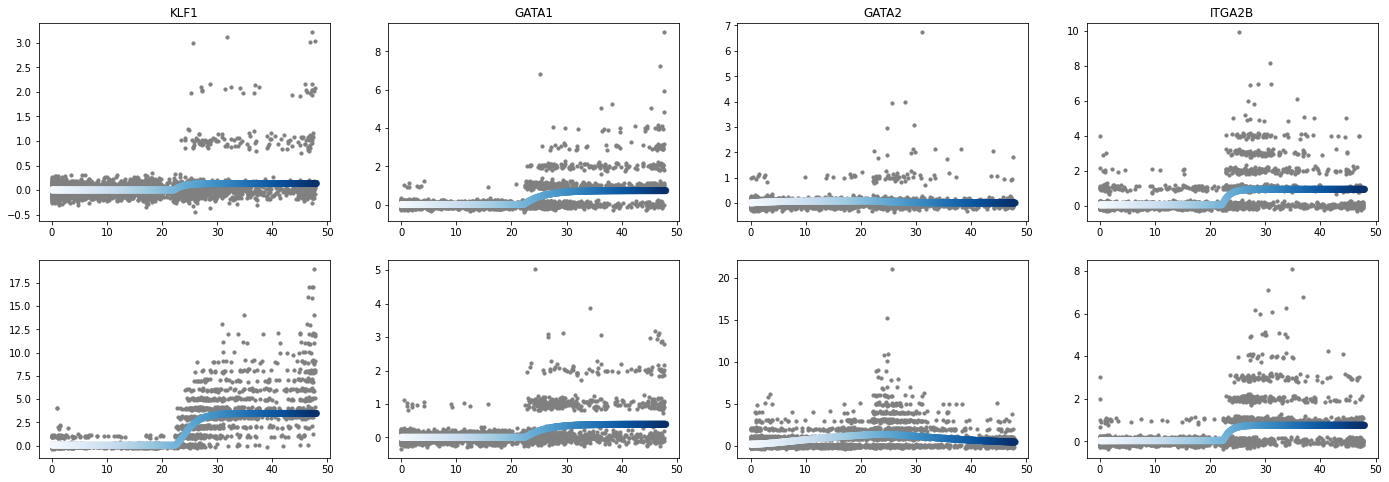

In [56]:
plot_y(traj,idx=plot_idx,gene_name=fitted_genes);

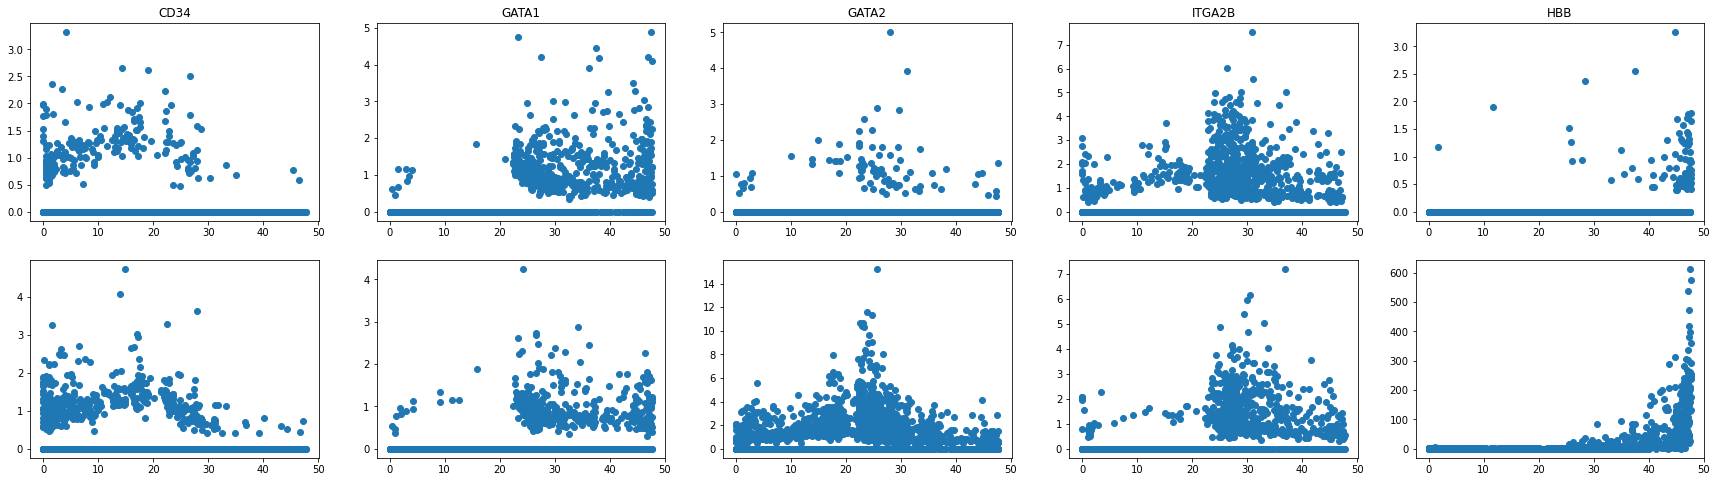

In [57]:
plot_marker_genes = ['CD34','GATA1','GATA2','ITGA2B','HBB']
fig,ax = plt.subplots(2,len(plot_marker_genes),figsize=(6*len(plot_marker_genes),8))
for i,gene in enumerate(plot_marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[0,i].set_title(gene)
    ax[0,i].scatter(traj.Q[:,0]@traj.t,adata.layers["unspliced"].toarray()[:,j]/rd)
    ax[1,i].scatter(traj.Q[:,0]@traj.t,adata.layers["spliced"].toarray()[:,j]/rd)

17


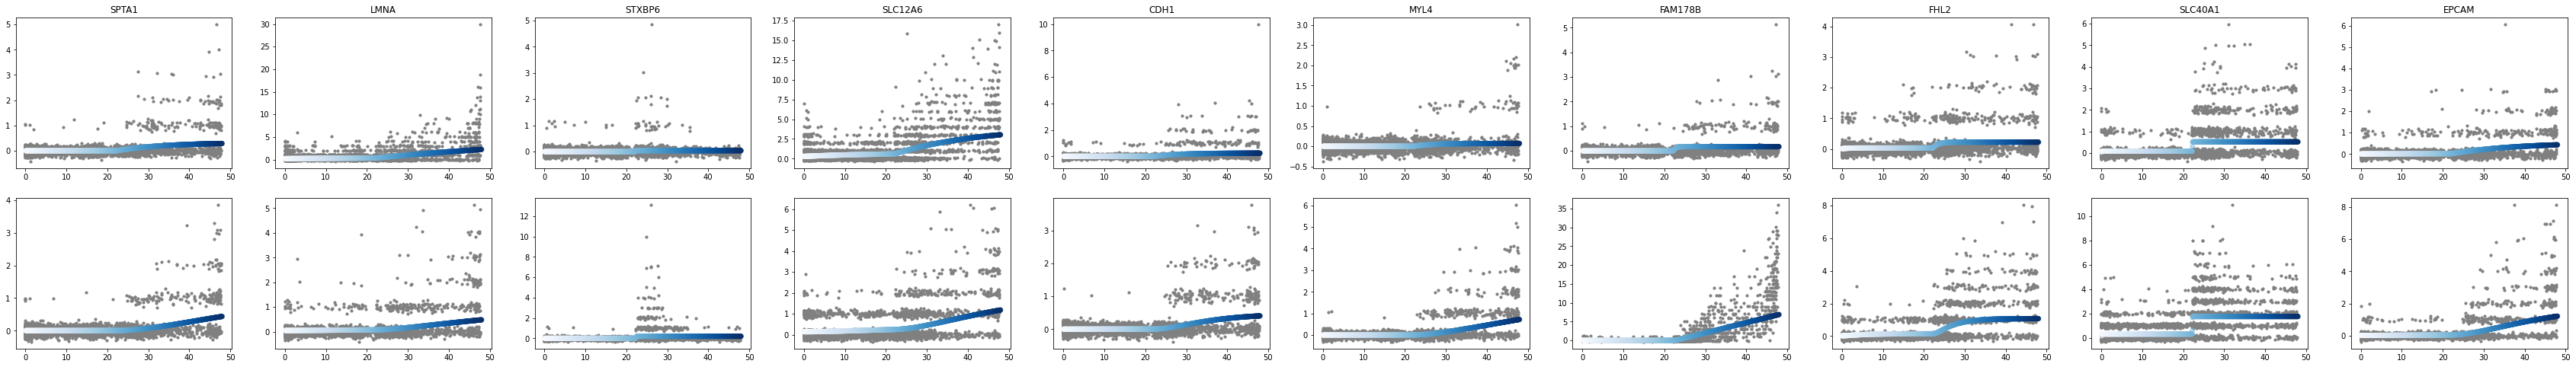

In [58]:
n, p, _ = X.shape
up_mask = (traj.theta[:,2] > 2*traj.theta[:,1]) & (traj.theta[:,1] > 2*traj.theta[:,0])
print(up_mask.sum())
up_idx = np.arange(p)[up_mask]
plot_y(traj,X=X,idx=up_idx[:10],gene_name=fitted_genes);

### two_species_ss_tau

In [59]:
tau = (0,24,48)
topo = np.array([[0,1,2]])
trajs = []
for seed in tqdm(range(20)):
    traj = Trajectory(topo, tau,  model="two_species_ss_tau", restrictions={}, verbose=0)
    traj = traj.fit(X, warm_start=False, params=params, n_init=1, perm_theta=False, parallel=True, epoch=10, n_threads=10, seed=seed)
    trajs.append(traj)

  0%|          | 0/20 [00:00<?, ?it/s]


NameError: name 'params' is not defined

In [ ]:
corrs = []
elbos = []
for traj in trajs:
    right_t = Q0[:,0] @ traj.t
    t_hat = traj.Q[:,0] @ traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

In [ ]:
traj = trajs[np.argmax(elbos)]

In [ ]:
plt.hist(traj.theta[:,-3])

In [ ]:
plot_y(traj,idx=plot_idx,gene_name=fitted_genes);

### two_species

In [ ]:
tau = (0,24,48)
topo = np.array([[0,1,2]])
trajs = []
for seed in tqdm(range(100)):
    traj = Trajectory(topo, tau,  model="two_species", restrictions={}, verbose=0)
    traj = traj.fit(X, warm_start=False, fit_tau=True, params=params, n_init=1, perm_theta=False, parallel=True, epoch=10, n_threads=10, seed=seed)
    trajs.append(traj)

In [ ]:
corrs = []
elbos = []
for traj in trajs:
    right_t = Q0[:,0] @ traj.t
    t_hat = traj.Q[:,0] @ traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

In [ ]:
traj = trajs[np.argmax(elbos)]
traj.elbos[0][-1]

In [ ]:
plt.scatter(traj.theta[:,-3],traj.theta[:,0]*traj.theta[:,-2]/traj.theta[:,-1])
plt.plot(traj.theta[:,-3],traj.theta[:,-3],color="lightgray")

In [ ]:
traj = trajs[np.argmax(corrs)]
traj.elbos[0][-1]

In [ ]:
plt.scatter(traj.theta[:,-3],traj.theta[:,0]*traj.theta[:,-2]/traj.theta[:,-1])
plt.plot(traj.theta[:,-3],traj.theta[:,-3],color="lightgray")

# Synthetic data

In [ ]:
m=100
weight0 = np.zeros((adata.n_obs,m))
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    weight0[idx,int(i*m/len(Clusters)):int((i+1)*m/len(Clusters))] += 1
weight0=weight0/weight0.sum(axis=1,keepdims=True)
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
Q0 = weight0[:,None]

topo = np.array([[0,1,2]])
tau = (0,24,48) # ~48 hours
traj = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj = traj.fit(X,warm_start=True,fit_tau=True,params=params,Q=Q0,parallel=True,n_threads=4,epoch=10)

In [ ]:
print(traj.elbos[-1])

In [ ]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

In [ ]:
plot_t(traj,order_cells=True)

In [ ]:
plt.plot(traj.Q.sum((0,1))/traj.Q.sum()*traj.m,'.')

In [ ]:
Y = traj.get_Y_hat(theta=traj.theta,t=traj.Q[:,0]@traj.t,tau=traj.tau,topo=traj.topo,params=traj.params)
syn_X = np.random.poisson(rd[:,None,None]*Y[0])
syn_t = traj.Q[:,0]@traj.t
plt.hist(syn_t,bins=traj.t);

In [ ]:
pp = min(10,len(plot_idx))
fix, ax = plt.subplots(1,pp,figsize=(6*pp,4))
for i in range(pp):
    j = plot_idx[i]
    ax[i].set_title(fitted_genes[j])
    ax[i].scatter(X[:,j,0]+np.random.normal(0,0.1,X.shape[0]),X[:,j,1]+np.random.normal(0,0.1,X.shape[0]),s=0.5,alpha=0.5) #,c=adata.obs['louvain'])

In [ ]:
syn_tau = traj.tau.copy()
syn_topo = traj.topo.copy()
trajs = []
for seed in tqdm(range(20)):
    syn_traj = Trajectory(syn_topo, syn_tau,  model="two_species_ss", restrictions={}, verbose=0)
    syn_traj = syn_traj.fit(syn_X, warm_start=False, fit_tau=False, params=params, n_init=1, perm_theta=False, parallel=True, epoch=10, n_threads=4, seed=seed)
    trajs.append(syn_traj)

In [ ]:
corrs = []
elbos = []
for syn_traj in trajs:
    right_t = syn_t
    t_hat = syn_traj.Q[:,0] @ syn_traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( syn_traj.elbos[np.argmax([syn_traj.elbos[i][-1] for i in range(len(syn_traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20',s=20,marker='*')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)